## Load libraries 

In [1]:
# Data analysis
import pandas as pd
import numpy as np

# ML
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_recall_fscore_support, precision_score, recall_score, cohen_kappa_score
from sklearn.decomposition import PCA 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
# from xgboost import plot_importance

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Miscs
import glob, os
from tqdm import tqdm, tqdm_notebook

/usr/local/lib64/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Load data

### First time only: create one single csv file

In [4]:
%%time
# path = './csvs/'
# all_files = glob.glob(os.path.join(path, "*.csv"))
# df = pd.concat((pd.read_csv(f) for f in all_files))

CPU times: user 3min 33s, sys: 887 ms, total: 3min 33s
Wall time: 3min 38s


In [5]:
# df.to_csv("./data/20200216.csv", index=False)

### Load a single csv file

In [4]:
%%time
df = pd.read_csv("./data/20200307.csv")

CPU times: user 1.82 s, sys: 82.4 ms, total: 1.9 s
Wall time: 2.36 s


Label-encode the target

In [6]:
df['label'] = np.where(df['label'] == 'EOG', 1, 0)

## ML

In [7]:
features = [f"map_component_{i}" for i in range(10)]

### Some PCA

In [8]:
pca = PCA(n_components=2)

In [9]:
df_scaled = df.drop(columns=['label', 'name'])[features].copy()
scaler = StandardScaler()
scaler.fit(df_scaled.values)
df_scaled = scaler.transform(df_scaled)
projected = pca.fit_transform(df_scaled)

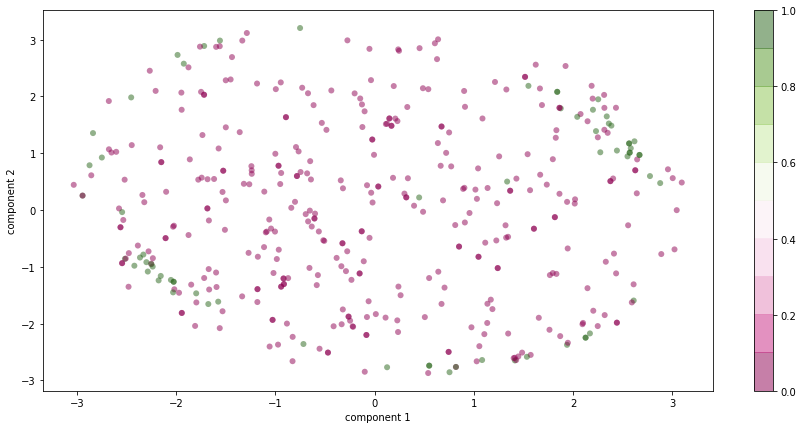

In [10]:
plt.figure(figsize=(15,7))
plt.scatter(projected[:, 0], projected[:, 1],
            c=df['label'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('PiYG', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Visually, Non-EOG and EOG points are not linearly separable

### Feature engineering

TODO...

### Data preparation

In [11]:
X = df.drop(columns=['label', 'name']).copy()
y = df['label'].copy()

### Model comparison

In [12]:
%%time
# Define models
svm_params = {}
xgb_params = {}
rf_params = {}
et_params = {}
# lr_params = {}
estimators = [
    ('Random forest', RandomForestClassifier(n_jobs=-1,random_state=2020,  **rf_params)),
    ('Extra trees', ExtraTreesClassifier(n_jobs=-1,random_state=2020,  **et_params)),
    ('Extreme gradient boosting', xgb.XGBClassifier(n_jobs=-1,random_state=2020,  **xgb_params)),
#     ('lr', LogisticRegression(random_state=2020,)),
    ('SVM', SVC(random_state=2020, **svm_params)),
]

# Cross validation: 3 folds
cv = StratifiedKFold(n_splits=3, shuffle=True,)
model_stats = pd.DataFrame(columns=['take', 'model', 'accuracy', 'precision', 'recall', 'f1'])
for i in tqdm(range(10)): # Run the experiment 10 times, each time the data will be split differently
    for name, clf in estimators:
        # Define pipeline
        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('classifier', clf)
        ], verbose=False)
        score = cross_validate(pipe, X[features], y, scoring=['f1', 'accuracy', 'recall', 'precision'], cv=cv, n_jobs=-1, verbose=False)
        model_stats = model_stats.append({
            'take': i+1,
            'model': name,
            'accuracy': score['test_accuracy'].mean(),
            'precision': score['test_precision'].mean(),
            'recall': score['test_recall'].mean(),
            'f1': score['test_f1'].mean()
        },ignore_index=True)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

CPU times: user 948 ms, sys: 58.8 ms, total: 1.01 s
Wall time: 13.7 s


In [15]:
model_stats.groupby('model').mean().sort_values(by=['f1'], ascending=[False])

,accuracy,precision,recall,f1
model,,,,
Extra trees,0.928854,0.833278,0.698551,0.752210
Random forest,0.927452,0.859167,0.652964,0.737128
SVM,0.913942,0.791362,0.627339,0.695998
Extreme gradient boosting,0.911174,0.781406,0.635968,0.692248


In [19]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":12})   

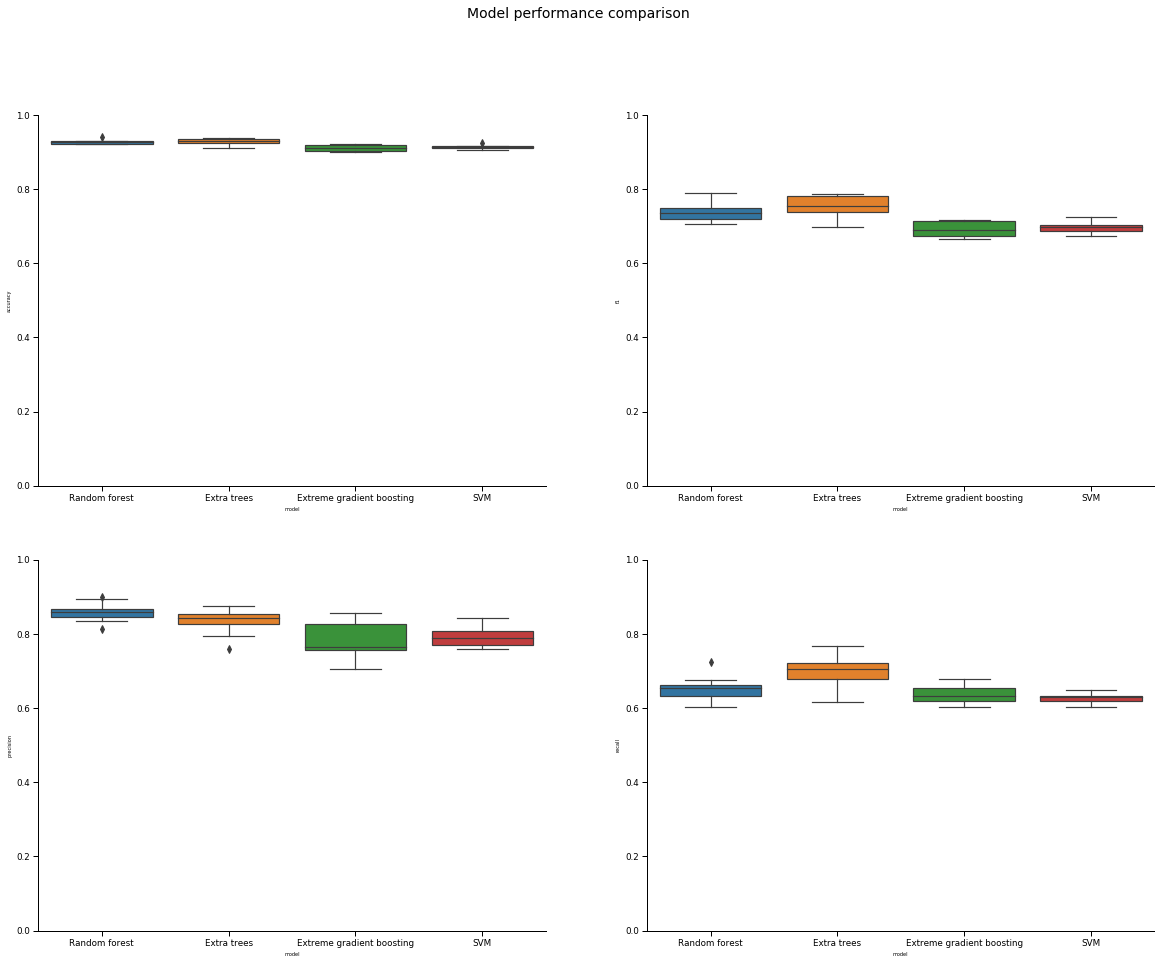

In [18]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
fig.suptitle('Model performance comparison', fontsize=14)
sns.boxplot(x='model', y='accuracy', data=model_stats, ax=ax[0][0])
sns.boxplot(x='model', y='f1', data=model_stats, ax=ax[0][1])
sns.boxplot(x='model', y='precision', data=model_stats, ax=ax[1][0])
sns.boxplot(x='model', y='recall', data=model_stats, ax=ax[1][1])
sns.despine()
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylim(0, 1)
# ax.set_ylabel('REcall score')